In [1]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
L = 1 
T = 1.0
Q0 = 1
alpha = 1
omega = 1


In [3]:
def pde_porous_medium(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=2)
    u_xx = dde.grad.hessian(u,x,i=0,j=0)
    u_yy = dde.grad.hessian(u,x,i=1,j=1)

    return u_t - alpha*(u_xx + u_yy) - Q0*(torch.ones_like(u_t)+torch.cos(omega*x[:,2:3]))



geom = dde.geometry.Rectangle(xmin=[0,0], xmax=[L,L])
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(x, on_boundary):
    return on_boundary


# условия нулевые на достаточно далеком иксе
bc= dde.DirichletBC(
    geomtime,
    lambda x: 0.0,           
    boundary
)





def on_initial(x, on_initial):
    return on_initial 

def ic_func(x):
                   
    return 0

ic = dde.IC(geomtime, ic_func, on_initial)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde_porous_medium,
    [bc,ic],
    num_domain=10000,
    num_boundary=500,
    num_initial=500,
)

net = dde.nn.FNN(
    [3] + [20] * 2 + [1],  
    "sin",
    "Glorot normal",
)

In [4]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
model.train(iterations=10000,callbacks=[resampler])
model.compile('L-BFGS')

losshistory, train_state = model.train()

Compiling model...
'compile' took 1.282060 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.44e+00, 1.03e-01, 1.68e-01]    [2.44e+00, 1.03e-01, 1.68e-01]    []  
1000      [7.53e-02, 2.81e-01, 7.97e-02]    [7.54e-02, 2.81e-01, 7.97e-02]    []  
2000      [4.13e-02, 4.67e-02, 1.50e-02]    [4.12e-02, 4.67e-02, 1.50e-02]    []  
3000      [3.21e-02, 9.62e-03, 4.13e-03]    [3.21e-02, 9.62e-03, 4.13e-03]    []  
4000      [2.06e-02, 4.63e-03, 2.90e-03]    [2.05e-02, 4.63e-03, 2.90e-03]    []  
5000      [1.46e-02, 3.29e-03, 2.60e-03]    [1.46e-02, 3.29e-03, 2.60e-03]    []  
6000      [1.00e-02, 2.58e-03, 2.48e-03]    [9.98e-03, 2.58e-03, 2.48e-03]    []  
7000      [6.29e-03, 2.09e-03, 2.41e-03]    [6.29e-03, 2.09e-03, 2.41e-03]    []  
8000      [3.91e-03, 1.96e-03, 2.43e-03]    [3.92e-03, 1.96e-03, 2.43e-03]    []  
9000      [2.67e-03, 1.91e-03, 2.41e-03]    [2.67e-03, 1.91e-03, 2.41e-03]    []  
10000     [1.78

Saving loss history to /home/ivan/MEPHI/nauchka/2dSource/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/2dSource/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/2dSource/test.dat ...


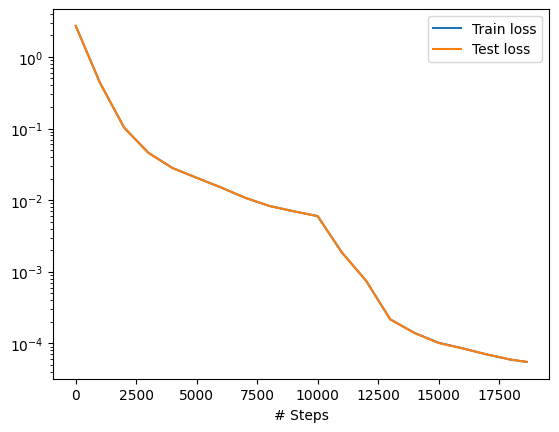

In [5]:
dde.saveplot(losshistory,train_state)

In [6]:
def solution(x,y,t, maxn = 100, maxm=100):
    u_res = np.zeros_like(x)
    for i in range(1,maxn,1):
        for j in range(1,maxm,1):
            lmn = alpha*np.pi**2*(i**2+j**2)
            Umn = 4*Q0/(np.pi**2*i*j)*((1-np.exp(-lmn*t))/lmn + (lmn*np.cos(omega*t) + omega*np.sin(omega*t)-lmn*np.exp(-lmn*t))/(lmn**2+omega**2))
            u_res+=Umn*np.sin(j*np.pi*x)*np.sin(np.pi*i*y)
    return u_res

Text(0.5, 0.92, 'exact solution')

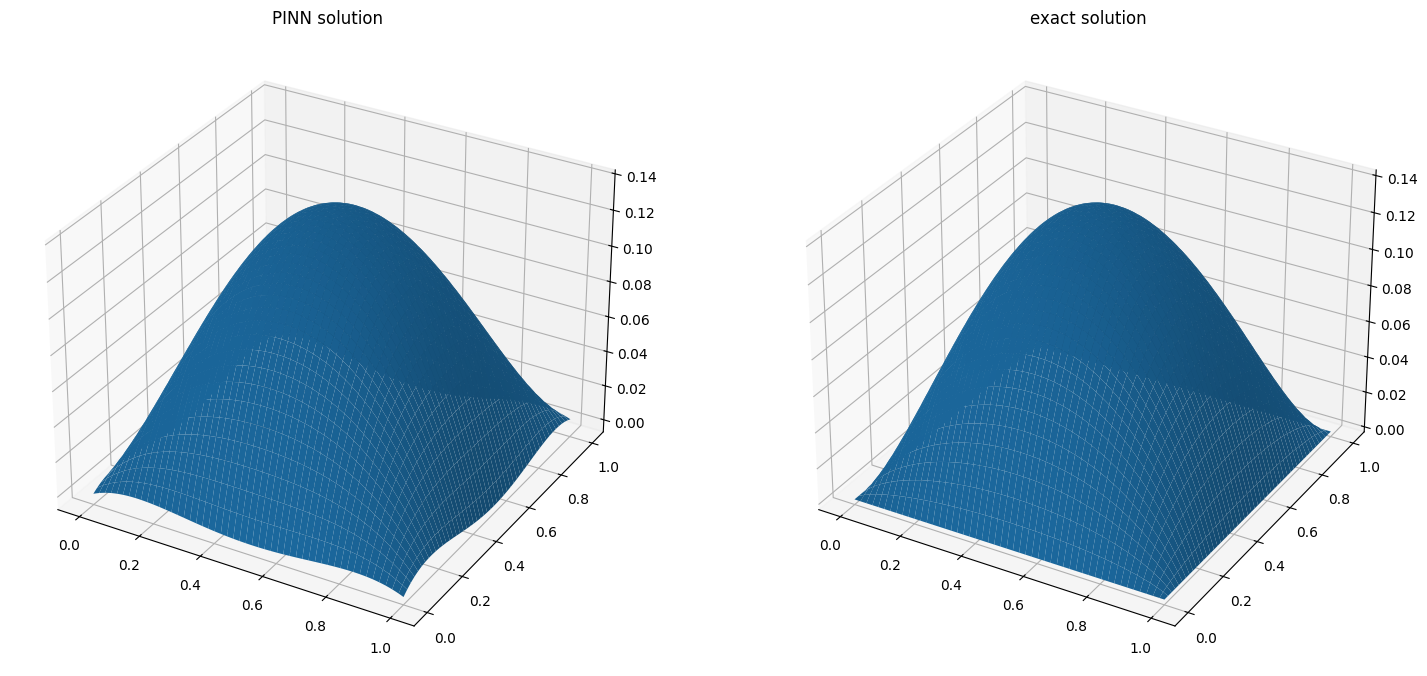

In [10]:
MAX_N = MAX_M = 101
NX = NY = 200


n_arr: np.ndarray = np.arange(1, MAX_N + 1, 2)
m_arr: np.ndarray = np.arange(1, MAX_M + 1, 2)
N_MODES, M_MODES = n_arr.size, m_arr.size


sigma: np.ndarray = alpha * np.pi**2 * (n_arr[:, None]**2 + m_arr[None, :]**2)


coeff0: np.ndarray = 16 * Q0 / (np.pi**2) / (n_arr[:, None] * m_arr[None, :])


x = np.linspace(0.0, L, NX)
y = np.linspace(0.0, L, NY)
Sx: np.ndarray = np.sin(np.pi * np.outer(x, n_arr))
Sy: np.ndarray = np.sin(np.pi * np.outer(y, m_arr)).T


def _coeff_time(t: float) -> np.ndarray:
    exp_neg = np.exp(-sigma * t)
    term_dc = (1.0 - exp_neg) / sigma
    term_ac = (
        sigma * np.cos(omega * t)
        + omega * np.sin(omega * t)
        - sigma * exp_neg
    ) / (sigma**2 + omega**2)
    return coeff0 * (term_dc + term_ac)


def spectral_solution(t: float) -> np.ndarray:
    C = _coeff_time(t)
    return np.einsum("in,nm,mj->ij", Sx, C, Sy, optimize="greedy")


X,Y = np.meshgrid(x,y)
XY = np.vstack((X.ravel(), Y.ravel(), 0.5*np.ones_like(Y.ravel()))).T
fig = plt.figure(figsize=(18, 15))
U_pinn   = model.predict(XY).reshape(200, 200)

ax = fig.add_subplot(1,2,1, projection = '3d')
ax.plot_surface(X,Y,U_pinn)
ax.set_title('PINN solution') 

ax = fig.add_subplot(1,2,2, projection = '3d')
ax.plot_surface(X,Y,spectral_solution(0.5))
ax.set_title('exact solution')

